<a href="https://colab.research.google.com/github/alphoenixbiz/AlphaCode-EXPLORE/blob/master/AlphaCode-EXPLORE/Submissions/Classification%20Model/predict02_Alfred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from pandas_profiling import ProfileReport
import seaborn as sn
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Install SQL Alchemy

In [0]:
!pip install sqlalchemy
!pip install pymssql

### Import packages

In [0]:
import sqlalchemy as sa
import pandas as pd
from sqlalchemy import create_engine

### Create a connection to our database

In [0]:
Username = 'admin'
Password = 'amazing_people'
Host = 'alphacode-explore.ccwgqdqrrmvt.eu-west-1.rds.amazonaws.com'
Port = '1433'
Database = 'Alfred'

### Create connection

In [0]:
connection = create_engine(
    'mssql+pymssql://' +
    Username + ':' + Password + '@' + Host + ':' + Port + '/' + Database
)

### What is the sql query we want to perform?

In [0]:
sql_query1 = "USE Alfred Select * from claims_data"
sql_query2 = "USE Alfred Select * from test_set"

 ### Using pandas we now take our connection and our query to create a dataframe

In [0]:
#import the training data
train = pd.read_sql_query(sql_query1, connection)
train.head()

,age,sex,bmi,steps,children,smoker,region,insurance_claim,claim_amount
0,19,female,27.900,3009,0,yes,southwest,yes,16884.9240
1,18,male,33.770,3008,1,no,southeast,yes,1725.5523
2,28,male,33.000,3009,3,no,southeast,no,0.0000
3,33,male,22.705,10009,0,no,northwest,no,0.0000
4,32,male,28.880,8010,0,no,northwest,yes,3866.8552


In [0]:
#import the test data
test = pd.read_sql_query(sql_query2, connection)
test.head()

,row_id,age,sex,bmi,steps,children,smoker,region
0,1,27,male,28.88,8049,0,False,southwest
1,2,20,female,26.265,7970,3,True,southwest
2,3,32,female,26.025,2973,0,False,southwest
3,4,19,female,22.085,10427,1,True,southwest
4,5,20,female,28.685,3972,0,True,southwest


In [0]:
# get the target variable
y = train.insurance_claim.values


In [0]:
train.drop(['insurance_claim','claim_amount'], axis=1,inplace=True)

In [0]:
subm = test.row_id.values

In [0]:
test.drop(['row_id'], axis=1,inplace=True)

# EDA

In [0]:
# Put all the features to gether for transformation
features = pd.concat([train, test],sort=False).reset_index(drop=True)
features['bmi'] = features['bmi'].astype(float)
features.head()

,age,sex,bmi,steps,children,smoker,region
0,19,female,27.900,3009,0,yes,southwest
1,18,male,33.770,3008,1,no,southeast
2,28,male,33.000,3009,3,no,southeast
3,33,male,22.705,10009,0,no,northwest
4,32,male,28.880,8010,0,no,northwest


In [0]:
# encode categorical variables
final_features = pd.get_dummies(features, sparse=False, drop_first=True)
final_features.head()

,age,bmi,steps,children,sex_male,smoker_True,smoker_no,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,3009,0,0,0,0,1,0,0,1
1,18,33.770,3008,1,1,0,1,0,0,1,0
2,28,33.000,3009,3,1,0,1,0,0,1,0
3,33,22.705,10009,0,1,0,1,0,1,0,0
4,32,28.880,8010,0,1,0,1,0,1,0,0


In [0]:
# Spliting the data back to train(X,y) and test
X = final_features.iloc[:len(y), :]
test = final_features.iloc[len(y):, :]
print('Features size for train(X,y) and test')
print('X', X.shape, 'y', y.shape, 'X_test', test.shape)

Features size for train(X,y) and test
X (1338, 11) y (1338,) X_test (300, 11)


In [0]:
# Split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 47)

**Model Building**

In [0]:
#import model
import xgboost as xgb
from xgboost import XGBClassifier
cls = XGBClassifier(n_estimators=65)

In [0]:
# train initial model
cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=65, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Making the predictions
pred1 = cls.predict(X_test)

**Model Evaluation**

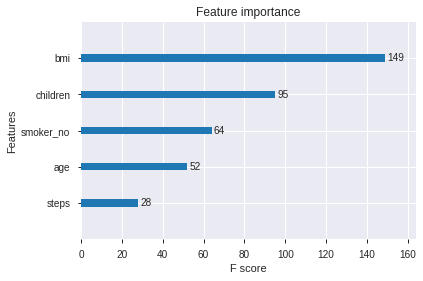

In [0]:
# Visualize feature importance
xgb.plot_importance(cls)
plt.show()

In [0]:
# performance matrics and model eveluation using sklearn.metrics inbuilt classification metric
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

          no       0.96      0.97      0.97       102
         yes       0.98      0.98      0.98       166

    accuracy                           0.97       268
   macro avg       0.97      0.97      0.97       268
weighted avg       0.97      0.97      0.97       268



In [0]:
# More auto EDA
profile = ProfileReport(X)
profile

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,11
Number of observations,1338
Total Missing (%),0.0%
Total size in memory,51.1 KiB
Average record size in memory,39.1 B
Numeric,4
Categorical,0
Boolean,6
Date,0
Text (Unique),0
Rejected,1


In [0]:
# Confusion Matrix Graph
cm = confusion_matrix(y_test, pred1)
cm

array([[ 99,   3],
       [  4, 162]])

Text(90.86111111111111, 0.5, 'Truth')

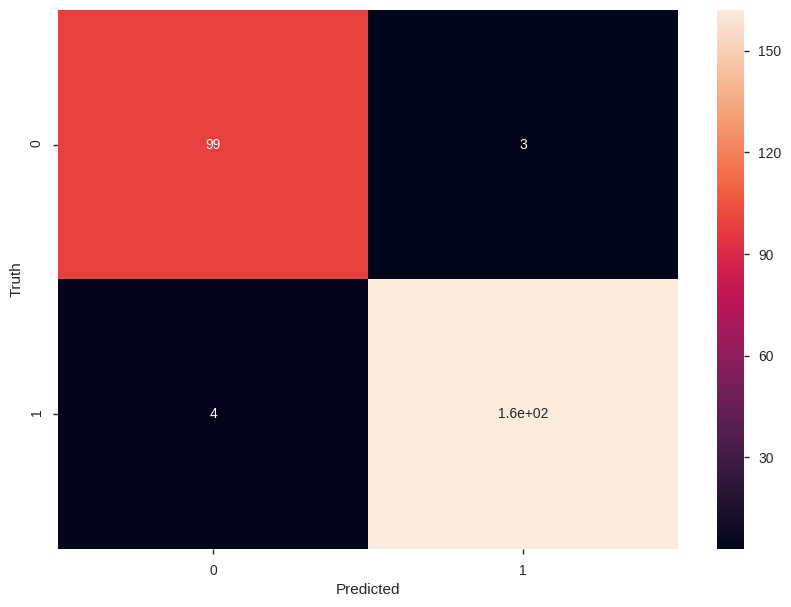

In [0]:
# Visualise Confusion Matrix
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Predictions**

In [0]:
# Final model training
cls.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=65, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Making final predictions
pred2 = cls.predict(test)


# submission

In [0]:
# save predictions
submission = pd.DataFrame({'row_id' : subm,'predictions' : pred2.ravel()}) 

In [0]:
submission.head()

,row_id,predictions
0,1,yes
1,2,no
2,3,yes
3,4,yes
4,5,yes


In [0]:
# result ratio
submission.predictions.value_counts()

yes    267
no      33
Name: predictions, dtype: int64

In [0]:
# submission.to_csv("gdrive/My Drive/Colab Notebooks/DATA/project_data/classification_model_results.csv", index=False)

In [0]:
submission.to_sql('classification_model_results', con=connection, if_exists='append', index=False,method='multi',chunksize=500)
